**Libraries**

In [5]:
!pip install tldextract

In [6]:
!pip install wordcloud

In [7]:
import pandas as pd
import numpy as np
import re
import tldextract
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [8]:
# Load the dataset
file_path = 'malicious_phish.csv'
df = pd.read_csv(file_path)

**Display dataset info**

In [9]:
print("\n Dataset Overview:\n")
print(df.info())


 Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120803 entries, 0 to 120802
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     120803 non-null  object
 1   type    120802 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None


**Show first few rows**

In [10]:
print("\n🔹 Sample Data:\n")
print(df.head())


🔹 Sample Data:

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


**Check for missing values**

In [11]:
print("\n🔹 Missing Values:\n")
print(df.isnull().sum())


🔹 Missing Values:

url     0
type    1
dtype: int64


**Unique class distribution**

<ipython-input-12-fa3685da63dc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type', palette='coolwarm')


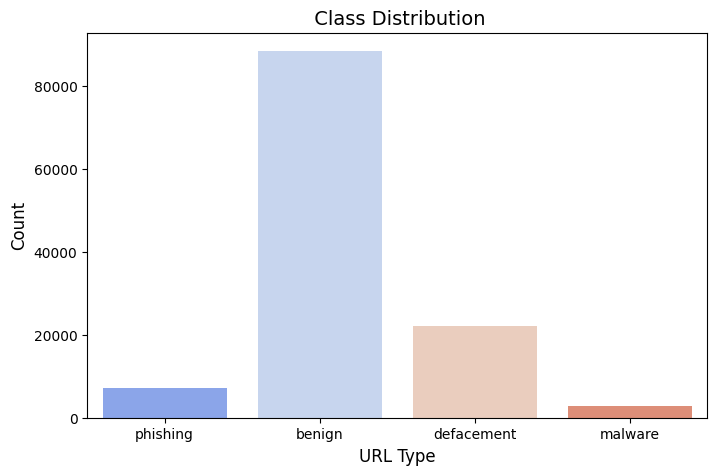

In [12]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', palette='coolwarm')
plt.title(" Class Distribution", fontsize=14)
plt.xlabel("URL Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

**WordCloud for URL patterns**

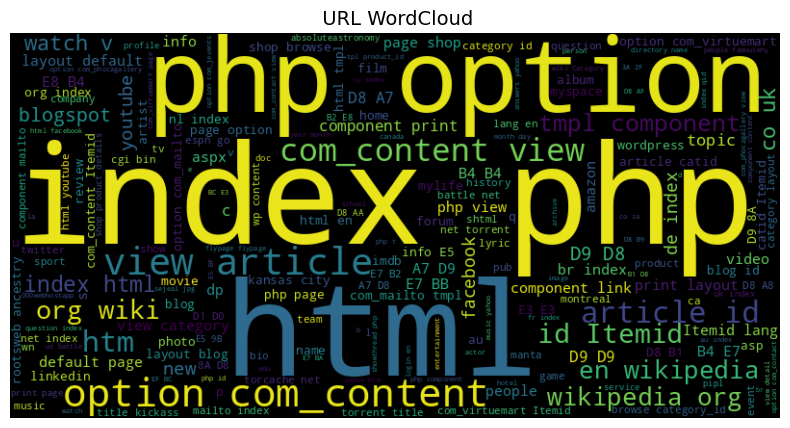

In [13]:
url_text = ' '.join(df['url'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(url_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(" URL WordCloud", fontsize=14)
plt.show()


**Extract and display stats of lexical features**

In [14]:
df['url_length'] = df['url'].apply(len)
df['digit_count'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))
df['special_char_count'] = df['url'].apply(lambda x: sum(not c.isalnum() for c in x))

# Display lexical feature statistics
print("\n Lexical Feature Stats:\n")
print(df[['url_length', 'digit_count', 'special_char_count']].describe())


 Lexical Feature Stats:

          url_length    digit_count  special_char_count
count  120803.000000  120803.000000       120803.000000
mean       59.518315       4.704130            9.466727
std        39.270954       9.317514            8.242704
min         6.000000       0.000000            0.000000
25%        32.000000       0.000000            4.000000
50%        49.000000       2.000000            7.000000
75%        79.000000       6.000000           13.000000
max      1517.000000    1054.000000          207.000000


**Visualizing lexical features**

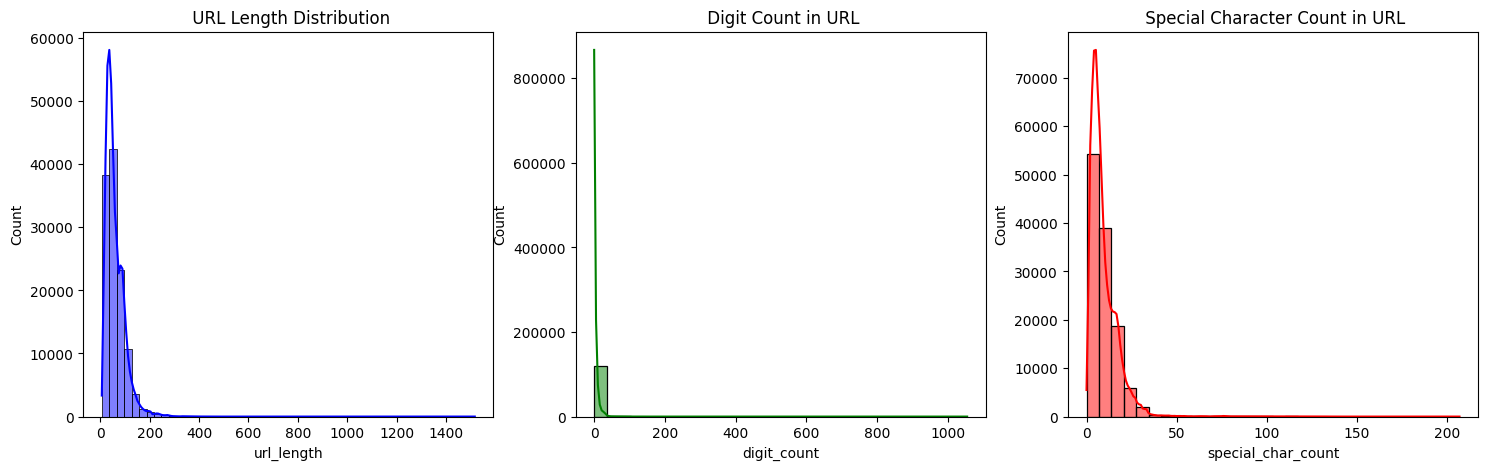

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['url_length'], bins=50, kde=True, ax=ax[0], color='blue')
ax[0].set_title(" URL Length Distribution")
sns.histplot(df['digit_count'], bins=30, kde=True, ax=ax[1], color='green')
ax[1].set_title(" Digit Count in URL")
sns.histplot(df['special_char_count'], bins=30, kde=True, ax=ax[2], color='red')
ax[2].set_title(" Special Character Count in URL")
plt.show()



# **Advanced Feature Engineering & Preprocessing**

**Lexical Feature Extraction**

In [16]:
def extract_lexical_features(url):
    return {
        "url_length": len(url),
        "num_digits": sum(c.isdigit() for c in url),
        "num_special_chars": len(re.findall(r'[^\w]', url)),
        "num_subdomains": url.count('.')
    }

lexical_features = df["url"].apply(lambda x: extract_lexical_features(str(x)))
lexical_df = pd.DataFrame(lexical_features.tolist())

**Host-Based Feature Extraction**

In [17]:
def extract_host_features(url):
    extracted = tldextract.extract(url)
    domain = f"{extracted.domain}.{extracted.suffix}"
    features = {"has_ip": 1 if re.match(r'\d+\.\d+\.\d+\.\d+', url) else 0}
    features["domain_length"] = len(domain)
    return features

host_features = df["url"].apply(lambda x: extract_host_features(str(x)))
host_df = pd.DataFrame(host_features.tolist())

**NLP-Based Feature Extraction**

In [18]:
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(2, 3))
tfidf_matrix = vectorizer.fit_transform(df["url"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])])

# Merge all features
df = pd.concat([df, lexical_df, host_df, tfidf_df], axis=1)

**Visualizing Feature Distributions**

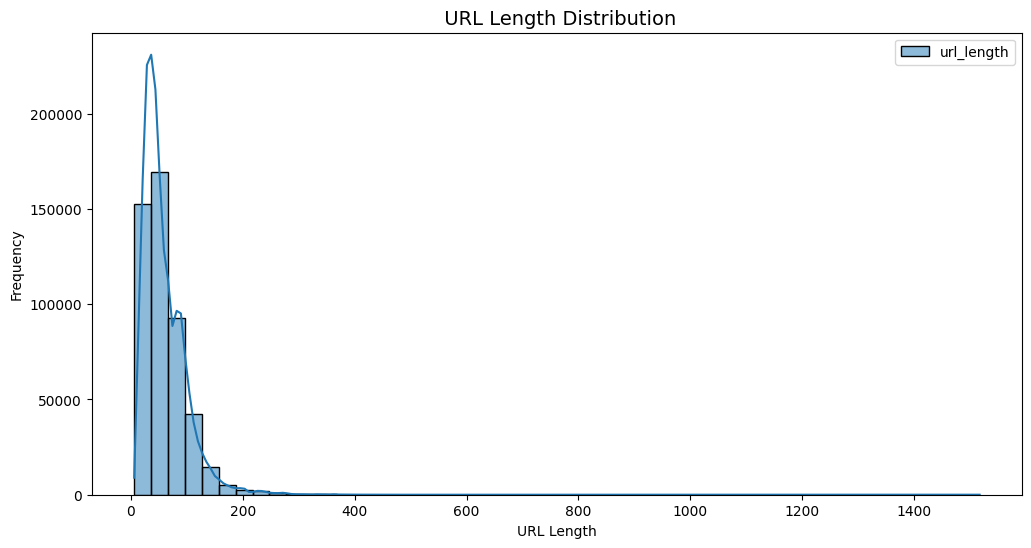

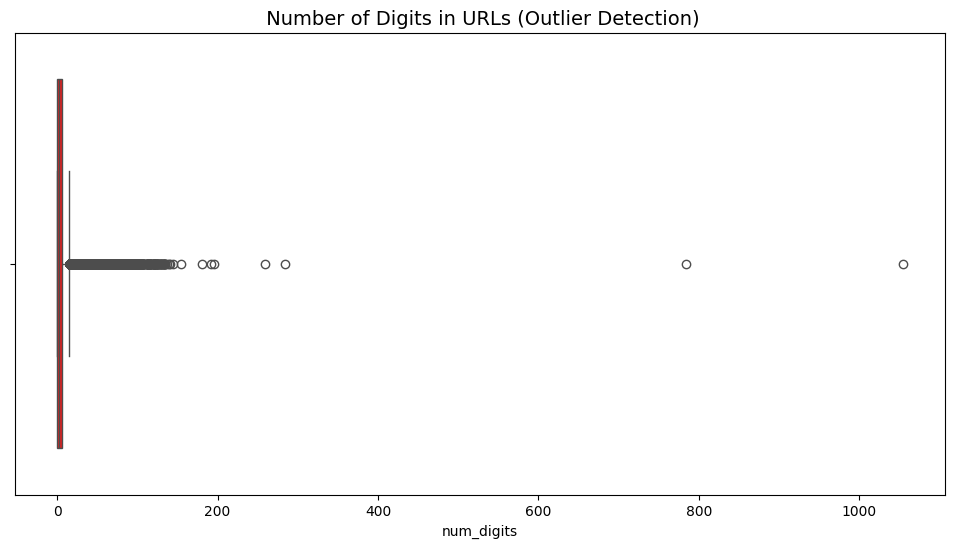

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(df['url_length'], bins=50, kde=True, color='blue')
plt.title(" URL Length Distribution", fontsize=14)
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['num_digits'], color='red')
plt.title(" Number of Digits in URLs (Outlier Detection)", fontsize=14)
plt.show()

**Correlation Heatmap**

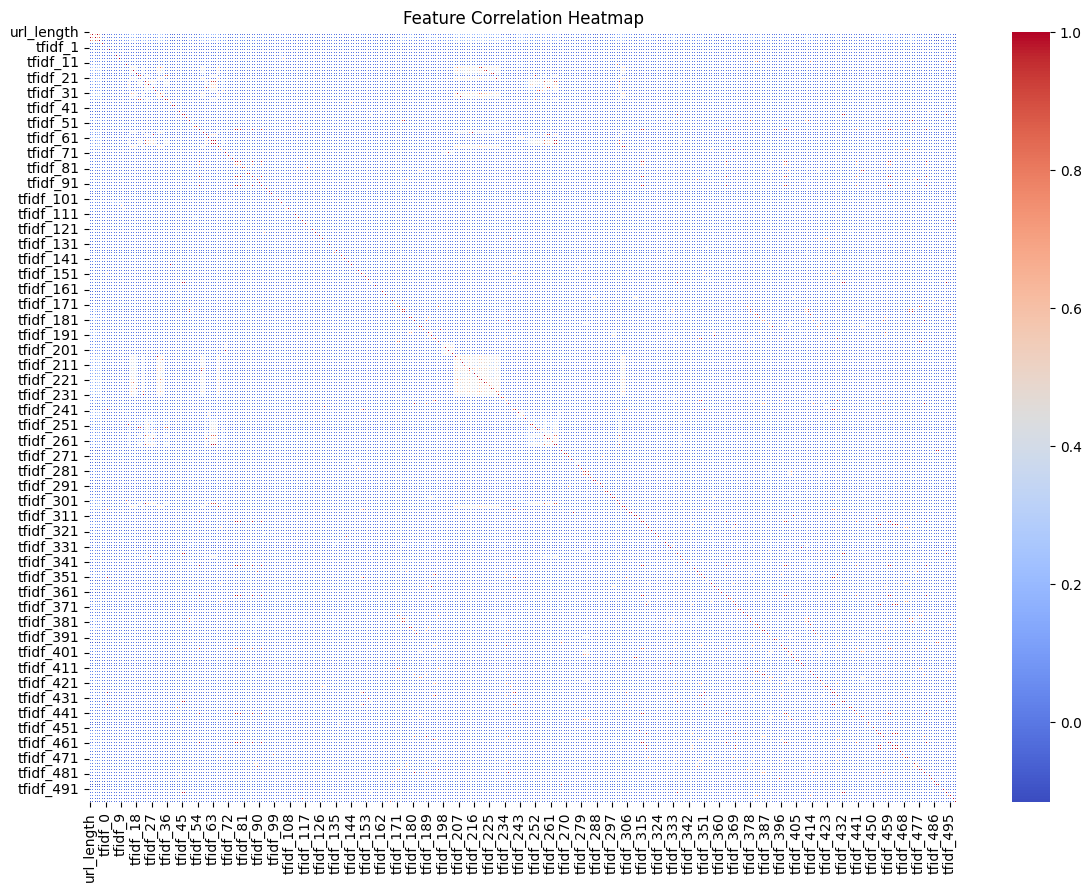

In [20]:
plt.figure(figsize=(14, 10))
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

**WordCloud for Most Common Words in Malicious URLs**

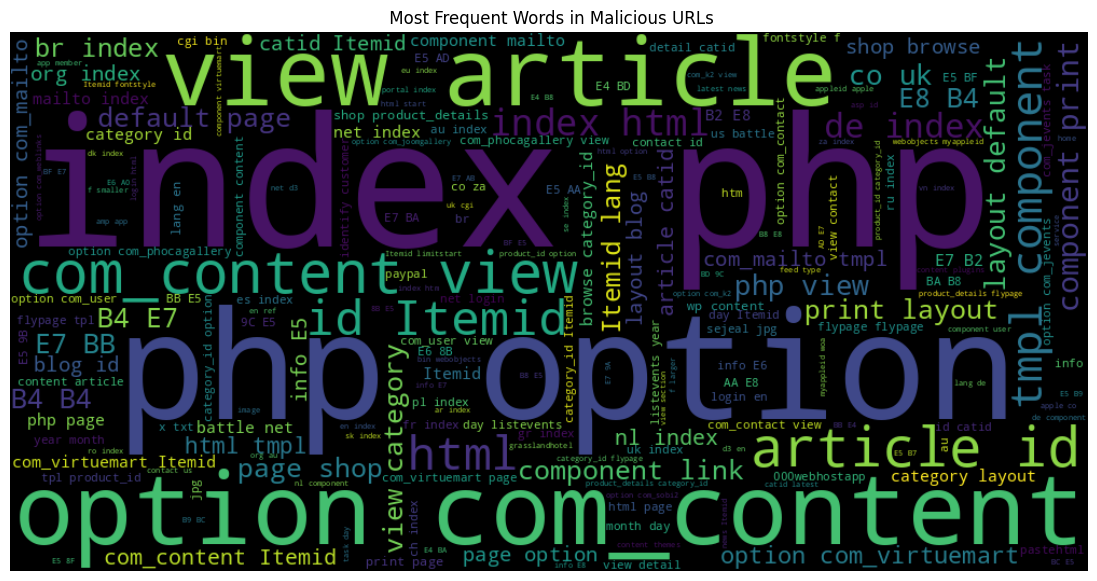

In [21]:
text = " ".join(df[df['type'] != 'benign']['url'])
wordcloud = WordCloud(width=1000, height=500, background_color='black').generate(text)
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(" Most Frequent Words in Malicious URLs")
plt.show()


**Feature Scaling**

In [22]:
scaler = StandardScaler()
feature_columns = [col for col in df.columns if col not in ["type", "url"]]
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# **Model Training & Evaluation**

**Additional Libraries**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings

warnings.filterwarnings("ignore")


**Converting categorical labels to numeric**

In [24]:
label_mapping = {"benign": 0, "phishing": 1, "defacement": 2}
df["label"] = df["type"].map(label_mapping)
df = df.drop(columns=["type", "url"])  # Remove non-numeric columns

In [25]:
# Handle missing values
df = df.fillna(0)

**Scale the dataset**

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=["label"]))
y = df["label"]

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Model Training**

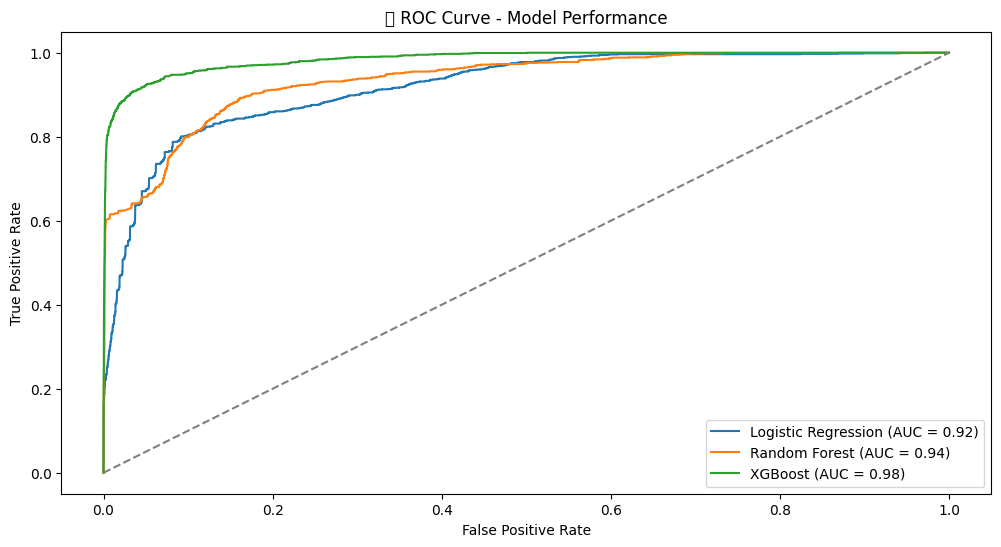

In [28]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100)
}

# Training and evaluating each model
results = {}
plt.figure(figsize=(12, 6))

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Store results
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# ROC Curve Visualization
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - Model Performance")
plt.legend()
plt.show()


**Model Results**


 Logistic Regression - Accuracy: 0.9220


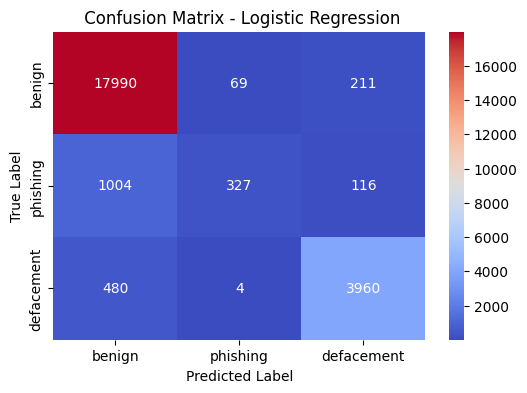


 Classification Report:
              precision    recall  f1-score       support
0.0            0.923796  0.984674  0.953264  18270.000000
1.0            0.817500  0.225985  0.354088   1447.000000
2.0            0.923723  0.891089  0.907113   4444.000000
accuracy       0.922023  0.922023  0.922023      0.922023
macro avg      0.888340  0.700583  0.738155  24161.000000
weighted avg   0.917416  0.922023  0.908891  24161.000000

 Random Forest - Accuracy: 0.9003


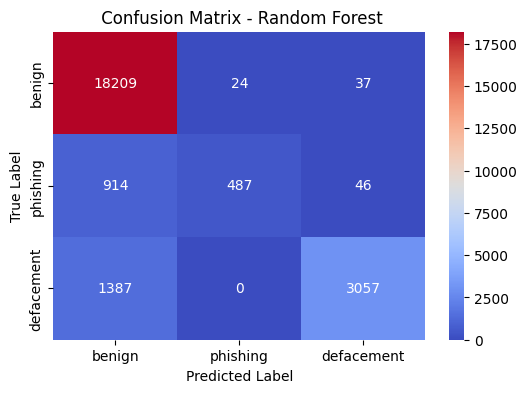


 Classification Report:
              precision    recall  f1-score       support
0.0            0.887811  0.996661  0.939092  18270.000000
1.0            0.953033  0.336558  0.497446   1447.000000
2.0            0.973567  0.687894  0.806171   4444.000000
accuracy       0.900335  0.900335  0.900335      0.900335
macro avg      0.938137  0.673704  0.747570  24161.000000
weighted avg   0.907490  0.900335  0.888194  24161.000000

 XGBoost - Accuracy: 0.9645


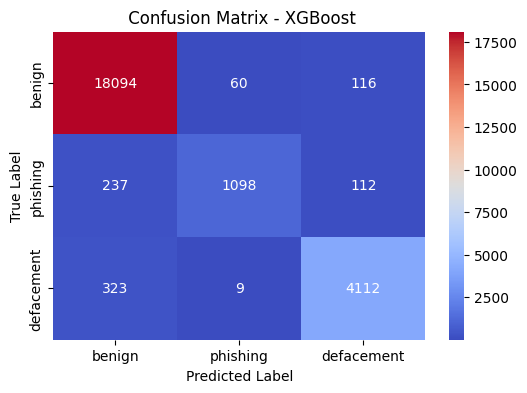


 Classification Report:
              precision    recall  f1-score      support
0.0            0.969980  0.990367  0.980067  18270.00000
1.0            0.940874  0.758811  0.840092   1447.00000
2.0            0.947465  0.925293  0.936248   4444.00000
accuracy       0.964530  0.964530  0.964530      0.96453
macro avg      0.952773  0.891490  0.918802  24161.00000
weighted avg   0.964095  0.964530  0.963624  24161.00000

 Model Training & Evaluation Completed Successfully! 


In [33]:
for name, result in results.items():
    print(f"\n {name} - Accuracy: {result['accuracy']:.4f}")

    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap="coolwarm", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.title(f" Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Classification Report
    print("\n Classification Report:")
    print(pd.DataFrame(result["classification_report"]).transpose())

print("\n Model Training & Evaluation Completed Successfully! ")

# **Deep Learning Model (Neural Network) for Phishing Detection**

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [38]:
df = df.fillna(0)

**Feature Scaling**

In [39]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=["label"]))
y = keras.utils.to_categorical(df["label"], num_classes=3)  # One-hot encoding

**Train-Test Split**

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["label"])

**Model Training**

In [41]:
# Build Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
3021/3021 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8999 - loss: 0.3188 - val_accuracy: 0.9337 - val_loss: 0.1908
Epoch 2/50
3021/3021 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9347 - loss: 0.1957 - val_accuracy: 0.9478 - val_loss: 0.1664
Epoch 3/50
3021/3021 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9449 - loss: 0.1700 - val_accuracy: 0.9501 - val_loss: 0.1531
Epoch 4/50
3021/3021 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9476 - loss: 0.1614 - val_accuracy: 0.9510 - val_loss: 0.1527
Epoch 5/50
3021/3021 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9507 - loss: 0.1536 - val_accuracy: 0.9520 - val_loss: 0.1521
Epoch 6/50
3021/3021 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9506 - loss: 0.1538 - val_accuracy: 0.9522 - val_loss: 0.1471
Epoch 7/50
3021/3021 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9521 - loss: 0.1498 - val_accuracy: 0.9532 - val_loss: 0.1446
Epoch 8/50
3021/3021 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9510 - loss: 0.1523

**Evaluation**

In [42]:
# Evaluate Model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Accuracy Score
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"\n Deep Learning Model Accuracy: {accuracy:.4f}")

756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

 Deep Learning Model Accuracy: 0.9540


**Confusion Matrix**

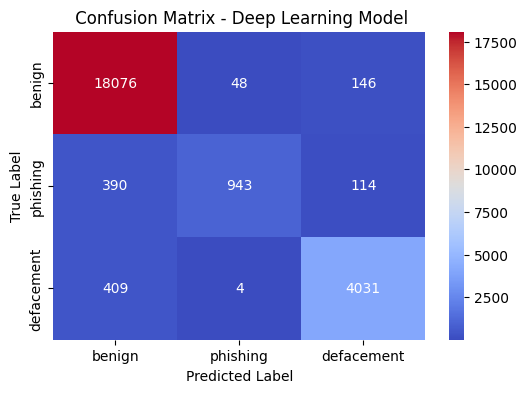

In [44]:
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title(" Confusion Matrix - Deep Learning Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Classification Report**

In [45]:
print("\n Classification Report:")
print(pd.DataFrame(classification_report(y_test_labels, y_pred, output_dict=True)).transpose())


 Classification Report:
              precision    recall  f1-score       support
0              0.957669  0.989381  0.973267  18270.000000
1              0.947739  0.651693  0.772318   1447.000000
2              0.939408  0.907066  0.922954   4444.000000
accuracy       0.954017  0.954017  0.954017      0.954017
macro avg      0.948272  0.849380  0.889513  24161.000000
weighted avg   0.953715  0.954017  0.951978  24161.000000


**Plotting Loss & Accuracy Curves**

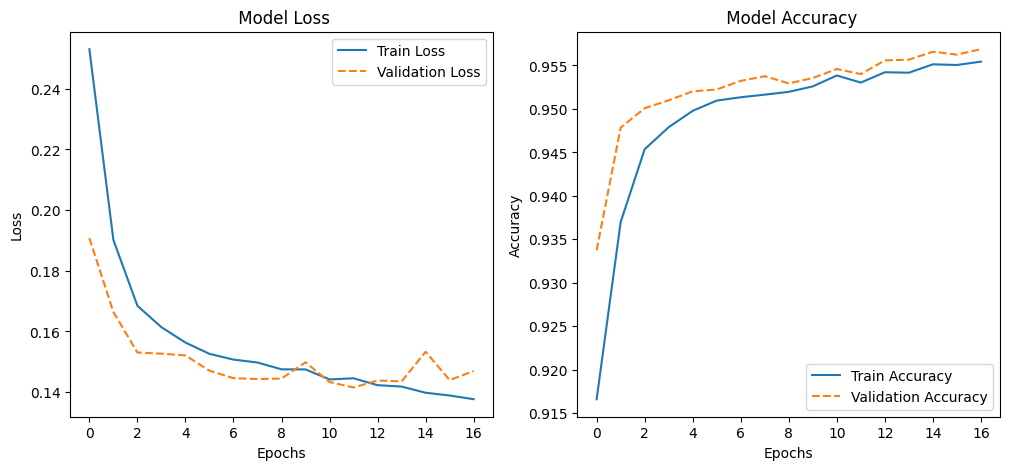

In [47]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.title(" Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.title(" Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


**ROC Curve**

756/756 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


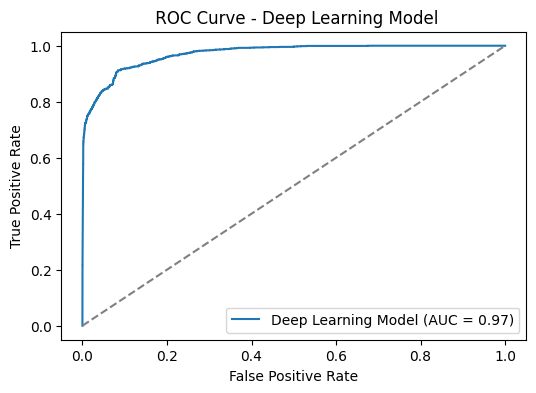

In [50]:
y_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test_labels, y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Deep Learning Model (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curve - Deep Learning Model")
plt.legend()
plt.show()